In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

In [2]:
import os

In [ ]:
# # installing retinanet
!git clone https://github.com/fizyr/keras-retinanet
os.chdir('keras-retinanet')
!python setup.py install

In [58]:
# import required libraries
import keras
import cv2
import keras_retinanet

In [ ]:
# # checking retinanent-train command
# !retinanet-train

In [5]:
os.chdir('/content/drive/MyDrive/Retinanet/Retinanet_logo_detection')  # redirect working dir to base folder
# base folder should contain folder with the dataset (images and annotations)

In [6]:
# indicate bash command
%%bash 
mkdir -p config   # create config folder
mkdir -p image_output # folder for predicted image
touch config/__init__.py # create __init__.py  file
touch config/logos_config.py # create logos_config.py  file
touch predict.py # create predict.py  file

In [7]:
%%writefile config/logos_config.py

import os

# initiaize the base path to the  dataset
BASE_PATH = 'logos'

# build the path to the annotations and input images
ANNOT_PATH = os.path.sep.join([BASE_PATH, 'annotations'])
IMAGES_PATH = os.path.sep.join([BASE_PATH, 'images'])
                              
# build the path to the training and testing .txt files
TRAIN_TXT = os.path.sep.join([BASE_PATH, "train.txt"])
TEST_TXT = os.path.sep.join([BASE_PATH, "test.txt"])

# build the path to the training and test .csv files
TRAIN_CSV = os.path.sep.join([BASE_PATH, "retinanet_train.csv"])
TEST_CSV = os.path.sep.join([BASE_PATH, "retinanet_test.csv"])

# build the path to the output classes CSV file
CLASSES_CSV = os.path.sep.join([BASE_PATH, "retinanet_classes.csv"])                            

Overwriting config/logos_config.py


In [ ]:
# download and copy the Resnet50_Coco file the logos directory
!wget https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5
!mv resnet50_coco_best_v2.1.0.h5 /content/drive/MyDrive/Retinanet/Retinanet_logo_detection/logos

In [8]:
%%writefile build_logos.py

# import the necessary packages
from config import logos_config as config
from bs4 import BeautifulSoup
import os

# initialize the set of classes we have encountered so far
CLASSES = set()

# create the list of datasets to build
datasets = [
	("train", config.TRAIN_TXT, config.TRAIN_CSV),
	("test", config.TEST_TXT, config.TEST_CSV),
]

# loop over the datasets
for (dType, inputTxt, outputCSV) in datasets:
	# load the contents of the input data split
	print("[INFO] starting '{}' set...".format(dType))
	imageIDs = open(inputTxt).read().strip().split("\n")
	print("[INFO] {} total images in '{}' set".format(
		len(imageIDs), dType))

	# open the output CSV file
	csv = open(outputCSV, "w")

	# loop over the image IDs
	for imageID in imageIDs:
		# build the path to the image path and annotation file
		imagePath = "{}.jpg".format(os.path.sep.join([
			config.IMAGES_PATH, imageID]))
		annotPath = "{}.xml".format(os.path.sep.join([
			config.ANNOT_PATH, imageID]))

		# load the annotation file, build the soup, and initialize
		# the set of coordinates for this particular image
		contents = open(annotPath).read()
		soup = BeautifulSoup(contents, "html.parser")
		coords = set()

		# extract the image dimensions
		w = int(soup.find("width").string)
		h = int(soup.find("height").string)

		# loop over all `object` elements
		for o in soup.find_all("object"):
			# extract the label and bounding box coordinates
			label = o.find("name").string
			xMin = int(o.find("xmin").string)
			yMin = int(o.find("ymin").string)
			xMax = int(o.find("xmax").string)
			yMax = int(o.find("ymax").string)

			# truncate any bounding box coordinates that may fall
			# outside the boundaries of the image
			xMin = max(0, xMin)
			yMin = max(0, yMin)
			xMax = min(w, xMax)
			yMax = min(h, yMax)

			# build a (hashable) tuple from the coordinates
			coord = (xMin, yMin, xMax, yMax)

			# if the coordinates already exist in our `coords` set,
			# ignore the annotation (this is a peculiarity of the
			# logos dataset)
			if coord in coords:
				continue

			# write the image path, bounding box coordinates, and
			# label to the output CSV file
			row = [os.path.abspath(imagePath), str(xMin), str(yMin),
				str(xMax), str(yMax), label]
			csv.write("{}\n".format(",".join(row)))

			# add the bounding box coordinates to our set and update
			# the set of class labels
			coords.add(coord)
			CLASSES.add(label)

	# close the output CSV file
	csv.close()

# write the classes to file
print("[INFO] writing classes...")
csv = open(config.CLASSES_CSV, "w")
rows = [",".join([c, str(i)]) for (i, c) in enumerate(CLASSES)]
csv.write("\n".join(rows))
csv.close()

Writing build_logos.py


In [9]:
# run build_logos.py
!python build_logos.py

[INFO] starting 'train' set...
[INFO] 748 total images in 'train' set
[INFO] starting 'test' set...
[INFO] 187 total images in 'test' set
[INFO] writing classes...


In [ ]:
# get number of files in train.csv
!wc -l logos/retinanet_train.csv

1393 logos/retinanet_train.csv


In [ ]:
1393//2

696

In [ ]:
# train model
!mkdir logos/snapshots
!retinanet-train --batch-size 2 --steps 374 --epochs 28 \
--weights logos/resnet50_coco_best_v2.1.0.h5 \
--snapshot-path logos/snapshots \
csv logos/retinanet_train.csv logos/retinanet_classes.csv

Creating model, this may take a second...
2021-11-23 13:51:22.940477: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
Model: "retinanet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1 (Conv2D)                 (No

In [7]:
# export model
!retinanet-convert-model logos/snapshots/resnet50_csv_12.h5 output.h5

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [8]:
# evaluate the model
!retinanet-evaluate csv logos/retinanet_test.csv \
logos/retinanet_classes.csv output.h5

Loading model, this may take a second...
2021-11-23 17:32:55.595364: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Running network: 100% (187 of 187) |######| Elapsed Time: 0:03:27 Time:  0:03:27
Parsing annotations: 100% (187 of 187) |##| Elapsed Time: 0:00:00 Time:  0:00:00
4 instances of class Atletico_Madrid with average precision: 0.7823
1 instances of class Facebook-Pict with average precision: 0.5000
5 instances of class Audi-Text with average precision: 0.0333
12 instances of class Ferrari-Pict with average precision: 0.5042
15 instances of class Ferrari-Text with average precision: 0.2118
30 instances of class CocaCola with average precision: 0.6867
17 instances of class Burger_king with average precision: 0.8643
21 instances of class Adidas-Text with average precision: 0.2888
19 instances of class Aldi with average precision: 0.4865
2

In [ ]:
os.chdir('/content/drive/MyDrive/Retinanet/Retinanet_logo_detection')

In [61]:
%%writefile predict.py

# import the necessary packages
from keras_retinanet.utils.image import preprocess_image
from keras_retinanet.utils.image import read_image_bgr
from keras_retinanet.utils.image import resize_image
from keras_retinanet import models
import numpy as np
import argparse
import cv2
from google.colab.patches import cv2_imshow
import PIL

# construct the argument parse and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-m", "--model", required=True,
	help="path to pre-trained model")
ap.add_argument("-l", "--labels", required=True,
	help="path to class labels")
ap.add_argument("-i", "--image", required=True,
	help="path to input image")
ap.add_argument("-c", "--confidence", type=float, default=0.5,
	help="minimum probability to filter weak detections")
args = vars(ap.parse_args())

# load the class label mappings
LABELS = open(args["labels"]).read().strip().split("\n")
LABELS = {int(L.split(",")[1]): L.split(",")[0] for L in LABELS}

# load the model from disk
model = models.load_model(args["model"], backbone_name="resnet50")

# load the input image (in BGR order), clone it, and preprocess it
image = read_image_bgr(args["image"])
output = image.copy()
image = preprocess_image(image)
(image, scale) = resize_image(image)
image = np.expand_dims(image, axis=0)

# detect objects in the input image and correct for the image scale
(boxes, scores, labels) = model.predict_on_batch(image)
boxes /= scale

# loop over the detections
for (box, score, label) in zip(boxes[0], scores[0], labels[0]):
	# filter out weak detections
	if score < args["confidence"]:
		continue

	# convert the bounding box coordinates from floats to integers
	box = box.astype("int")

	# build the label and draw the label + bounding box on the output
	# image
	label = "{}: {:.2f}".format(LABELS[label], score)
	cv2.rectangle(output, (box[0], box[1]), (box[2], box[3]),
		(0, 255, 0), 2)
	cv2.putText(output, label, (box[0], box[1] - 10),
		cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
 
# save the output image
cv2.imwrite('image_output/output.jpg', output)

Overwriting predict.py


In [62]:
# test the model on a sample image
!python predict.py --model output.h5 --labels logos/retinanet_classes.csv \
--image logos/images/238423.jpg --confidence 0.5

2021-11-23 19:27:14.790378: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


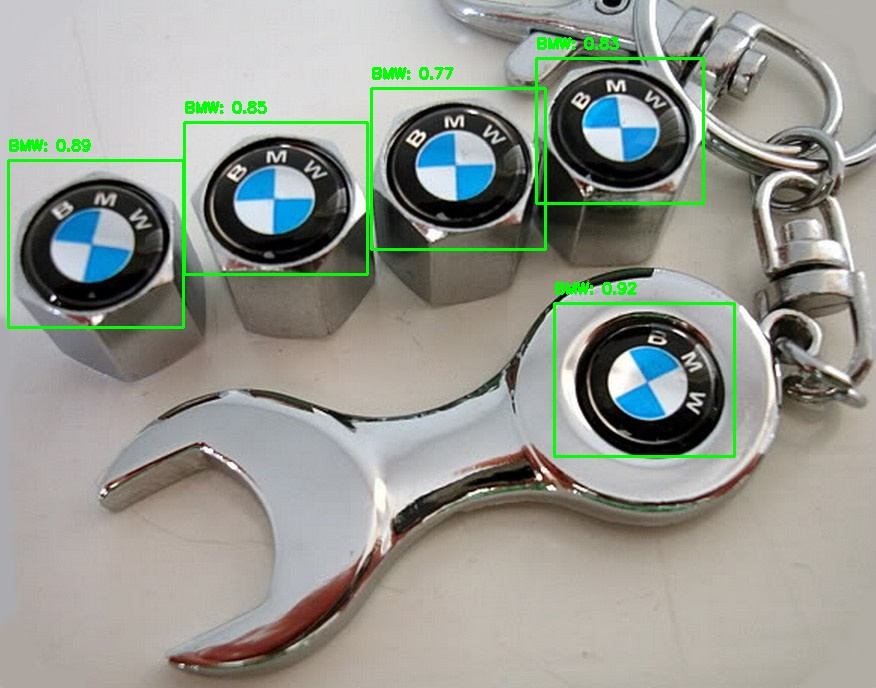

In [63]:
# show predicted image
image = cv2.imread('image_output/output.jpg')
cv2_imshow(image)